# 强化学习第一次实验 Multi-Armed Bandits

本notebook编程实现多臂老虎机问题。

每个手臂回报对应的概率分布均为正态分布。

考虑了以下两种情况：

* 每个手臂回报对应的概率分布是静态的（stationary）
* 每个手臂回报对应的概率分布是动态的（nonstationary）

实验主要使用了两种方法：

* $\epsilon$-greedy method
* gradient bandit algorithm

在$\epsilon$-greedy method中，探索了$\epsilon$,$\alpha$,initial values参数的设置，从中选取最优。

在gradient bandit algorithm中，探索了$\alpha$等参数的设置，从中选取最优。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
import itertools
from tqdm import tqdm

### 定义一个Bandit类

默认有10个臂，每个手臂回报概率为正态分布。静态情况下，均值由均值为0方差为1的正态分布产生，方差为1。动态情况下，均值从0出发，以均值为0方差为0.1的正态分布随机生成步长行进，方差为1。

In [61]:
class Bandit():
    
    def __init__(self,num_arm=10,means=None,stationary=True):
        if means:
            self.means=means
            self.num_arm=len(means)
        else:
            self.num_arm=num_arm
            self.means=np.random.randn(self.num_arm)
        
        self.variances=np.ones(self.num_arm)
        self.bestchoice=np.argmax(self.means)
        self.stationary=stationary
        if not stationary:
            self.means=np.zeros(self.num_arm)
        
    
    def GiveReward(self,choice):
        #print(self.means[choice])
        #print(self.variances[choice])
        if not self.stationary:
            #动态情况，每一步给means加上一个随机生成的数
            walk=np.random.normal(0,0.01,self.num_arm)
            #print(walk)
            self.means+=walk
            #print(self.means)
            self.bestchoice=np.argmax(self.means)
            
        return np.random.normal(self.means[choice],self.variances[choice])
        
    def ShowDistribution(self):
        print('There are {} arms.'.format(self.num_arm))
        print('The means are {}.'.format(self.means))
        print('The variances are {}.'.format(self.variances))
        print('The best choice is {}.'.format(self.bestchoice))
        
    def Reset(self):
        if not self.stationary:
            self.means=np.zeros(self.num_arm)

测试一下

In [3]:
bandit=Bandit()
means=bandit.means
bandit.ShowDistribution()
print(bandit.GiveReward(0))

There are 10 arms.
The means are [ 1.27273425 -1.13847937 -0.43136774 -0.53453805 -1.61693912 -0.37743463
 -1.48015692  0.95858714 -0.8192603  -2.06815483].
The variances are [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.].
The best choice is 0.
0.46036190015110723


### 定义各种方法

EpsilonGreedyMethod，输入一个bandit问题，同时传入参数，返回收益列表和每一步是否最优列表。

参数:

* bandit:所需解决的问题
* n:迭代步长
* epsilon:随机选择的概率
* alpha:步长，alpha=0时即为sample-average
* epsilon_decreasing:是否采用衰减的epsilon,若是，从初始值衰减至0.0001
* initial_values:是否使用人工设置的初始估计，若否，初始估计为0

In [78]:
def EpsilonGreedy(bandit,n=1000,epsilon=0,alpha=0,epsilon_decreasing=False,initial_values=None):
    k=bandit.num_arm
    if initial_values is None:
        initial_values=np.zeros(k)   #如果没有指定初始值，使用0初始化估计
    rewards=np.zeros(n)   #保存每次的回报
    acc=np.zeros(n)   #保存每次是否选择了最优
    Na=np.zeros(k)   #用来为每个action计数
    Qa=initial_values.copy()   #每个action的估计
    epsilon_0=epsilon
    for i in range(n):
        
        if epsilon_decreasing and epsilon_0!=0:
            #选择了epsilon随时间衰减
            epsilon=(0.0001-epsilon_0)/(n-1)*i+epsilon_0
        
        #print(epsilon)
        p=np.random.rand()
        if p>=epsilon:
            #贪心
            choice=np.argmax(Qa)
        else:
            #随机
            choice=np.random.randint(0,k)
        
        reward=bandit.GiveReward(choice)
        #更新估计
        Na[choice]+=1
        if alpha!=0:
            #alpha为不为零常数，step-size parameter
            Qa[choice]+=(reward-Qa[choice])*alpha
        else:
            #alpha不为常数，使用sample-average method
            Qa[choice]+=(reward-Qa[choice])/Na[choice]
        #更新记录
        rewards[i]=reward
        acc[i]=(choice==bandit.bestchoice)
        #print(Qa)
        #print(choice)
        #print(Na)
        #print(reward)
    return rewards,acc

GradientMethod，输入一个bandit问题，同时传入参数，返回收益列表和每一步是否最优列表。

参数:

* bandit:所需解决的问题
* n:迭代步长
* alpha:步长
* alpha_average:计算均值的步长，alpha_average=0时直接计算均值，alpha_average为常数时更关注近的回报

In [5]:
def GradientMethod(bandit,n=1000,alpha=0.1,alpha_average=0):
    k=bandit.num_arm
    rewards=np.zeros(n)   #保存每次的回报
    acc=np.zeros(n)   #保存每次是否选择了最优
    Ha=np.zeros(k)   #偏好函数，初始化为零
    pia=np.array([1/k for i in range(k)])   #各action概率，均初始化为1/k
    R_average=0   #记录均值
    for i in range(n):
        choice=np.random.choice([j for j in range(k)],p=pia)
        R=bandit.GiveReward(choice)
        #更新偏好函数,概率值和均值
        tmp=Ha[choice]+alpha*(R-R_average)*(1-pia[choice])   #为了不用循环，先算choice对应的偏好函数并记录下来
        Ha-=alpha*(R-R_average)*pia
        Ha[choice]=tmp
        zzy=np.exp(Ha)
        pia=zzy/np.sum(zzy)
        if alpha_average!=0:
            R_average+=(R-R_average)*alpha_average
        else:
            R_average+=(R-R_average)/(i+1)
        #记录
        rewards[i]=R
        acc[i]=(choice==bandit.bestchoice)
    return rewards,acc

### 实验

配置参数。

#### 首先是静态情况。

In [3]:
epsilon_setting=[0,0.1,0.01]
epsilon_decreasing_setting=[False,True]
alpha_setting=[0,0.1,0.2]
initial_values_setting=[None,np.array([5 for i in range(10)],dtype=np.float)]   

settings={}
settings['k']=10
settings['times']=2000
settings['n']=1000
settings['stationary']=True
for i,x in enumerate(itertools.product(epsilon_setting,epsilon_decreasing_setting,alpha_setting,initial_values_setting)):
    settings[i]={}
    settings[i]['epsilon']=x[0]
    settings[i]['epsilon_decreasing']=x[1]
    settings[i]['alpha']=x[2]
    settings[i]['initial_values']=x[3]
    
alpha_setting=[0.1,0.4]
alpha_average_setting=[0,0.1,0.2]
for i,x in enumerate(itertools.product(alpha_setting,alpha_average_setting)):
    settings[36+i]={}
    settings[36+i]['alpha']=x[0]
    settings[36+i]['alpha_average']=x[1]
for i in range(42):
    print(i,settings[i])

0 {'epsilon': 0, 'epsilon_decreasing': False, 'alpha': 0, 'initial_values': None}
1 {'epsilon': 0, 'epsilon_decreasing': False, 'alpha': 0, 'initial_values': array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])}
2 {'epsilon': 0, 'epsilon_decreasing': False, 'alpha': 0.1, 'initial_values': None}
3 {'epsilon': 0, 'epsilon_decreasing': False, 'alpha': 0.1, 'initial_values': array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])}
4 {'epsilon': 0, 'epsilon_decreasing': False, 'alpha': 0.2, 'initial_values': None}
5 {'epsilon': 0, 'epsilon_decreasing': False, 'alpha': 0.2, 'initial_values': array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])}
6 {'epsilon': 0, 'epsilon_decreasing': True, 'alpha': 0, 'initial_values': None}
7 {'epsilon': 0, 'epsilon_decreasing': True, 'alpha': 0, 'initial_values': array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])}
8 {'epsilon': 0, 'epsilon_decreasing': True, 'alpha': 0.1, 'initial_values': None}
9 {'epsilon': 0, 'epsilon_decreasing': True, 'alpha': 0.1, 'initial_values': array(

共有42个不同参数配置的方法，其中前36个是$\epsilon$-greedy method，后6个是gradient bandit algorithm。

下面定义测试函数并进行实验。

In [87]:
def experiment(settings):
    n=settings['n']
    T=settings['times']
    k=settings['k']
    n_settings=len(settings)-4
    rewards=np.zeros((n_settings,n))
    acc=np.zeros((n_settings,n))
    for j in tqdm(range(T)):
        #实验T次
        bandit=Bandit(num_arm=k,stationary=settings['stationary'])
        #bandit.ShowDistribution()
        for i in range(n_settings):
            #bandit.ShowDistribution()
            setting=settings[i]
            if 'epsilon' in setting.keys():
                r,a=EpsilonGreedy(bandit,n,setting['epsilon'],setting['alpha'],setting['epsilon_decreasing'],setting['initial_values'])
            else:
                r,a=GradientMethod(bandit,n,setting['alpha'],setting['alpha_average'])
            rewards[i]+=r
            acc[i]+=a
            #bandit.ShowDistribution()
            bandit.Reset()
    return rewards/T,acc/T

#rewards,acc=experiment(settings)
#np.save('1.npy',rewards)
#np.save('2.npy',acc)

我们选取几个具有代表性的画图。

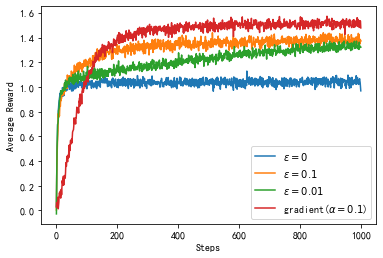

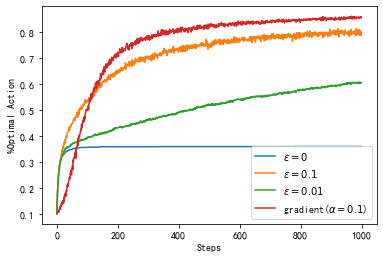

In [26]:
rewards=np.load('1.npy')
acc=np.load('2.npy')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.plot([i for i in range(1000)],rewards[0],label=r'$\epsilon=0$')
plt.plot([i for i in range(1000)],rewards[12],label=r'$\epsilon=0.1$')
plt.plot([i for i in range(1000)],rewards[24],label=r'$\epsilon=0.01$')
plt.plot([i for i in range(1000)],rewards[36],label=r'gradient($\alpha=0.1$)')
plt.legend()
plt.show()
plt.xlabel('Steps')
plt.ylabel('%Optimal Action')
plt.plot([i for i in range(1000)],acc[0],label=r'$\epsilon=0$')
plt.plot([i for i in range(1000)],acc[12],label=r'$\epsilon=0.1$')
plt.plot([i for i in range(1000)],acc[24],label=r'$\epsilon=0.01$')
plt.plot([i for i in range(1000)],acc[36],label=r'gradient($\alpha=0.1$)')
plt.legend()
plt.show()

我们认为在1000个step中具有最高平均收益（总收益）的方法为最优

以下为不同方案的期望回报:
[1.03085004 1.41853768 1.22487363 1.31041163 1.33113996 1.38282304
 1.02607075 1.42333267 1.2258688  1.31042817 1.33555185 1.38262653
 1.314093   1.34131343 1.26454394 1.20394285 1.30604701 1.25307819
 1.37772291 1.40793466 1.31132865 1.27292261 1.37620817 1.32825239
 1.21300178 1.42451947 1.24636694 1.30058217 1.35491496 1.36867165
 1.17643464 1.42426675 1.23998609 1.30730292 1.35032615 1.37602459
 1.37432425 1.37201942 1.37336286 1.39742057 1.39884316 1.40416791]
最优的方案是25号:{'epsilon': 0.01, 'epsilon_decreasing': False, 'alpha': 0, 'initial_values': array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])}


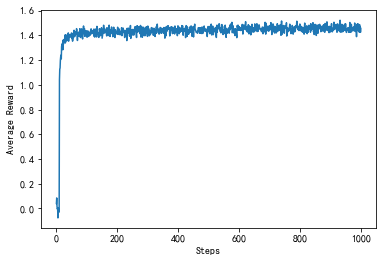

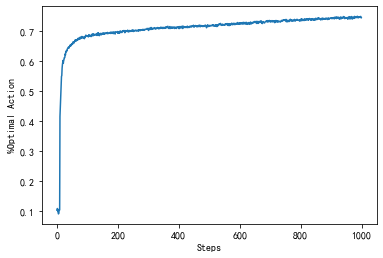

In [27]:
optimal_id=np.argmax(np.average(rewards,1))
print('以下为不同方案的期望回报:')
print(np.average(rewards,1))
print('最优的方案是{}号:{}'.format(optimal_id,settings[optimal_id]))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.plot([i for i in range(1000)],rewards[optimal_id])
plt.show()
plt.xlabel('Steps')
plt.ylabel('%Optimal Action')
plt.plot([i for i in range(1000)],acc[optimal_id])
plt.show()

最佳的方案为$\epsilon=0.01$,$\epsilon$不随时间变化，$\alpha$采用sample-average，初始估计设置为明显大于实际值。

这种方案由于设置了较高的初始估计，每个action都至少被选择了一次，可以迅速地找到较优的选择，同时较小的$\epsilon$避免了过多探索。

但需要注意的是，当step增加时，选择到最优的概率增长非常缓慢。所以当设置的最大step变化时，它可能不再是最优的方案。由于计算量过大，我们在这仅选取一个增加了$\epsilon$衰减的方案和一个梯度方法，将step增加至4000，与其进行比较。

In [113]:
newsettings={}
newsettings['k']=10
newsettings['times']=2000
newsettings['n']=4000
newsettings['stationary']=True
newsettings[0]=settings[25]   
newsettings[1]=settings[31]
newsettings[2]=settings[36]
rewards,acc=experiment(newsettings)
np.save('3.npy',rewards)
np.save('4.npy',acc)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [11:22<00:00,  2.93it/s]


以下为不同方案的期望回报:
[1.45470118 1.45691852 1.48002471]
最优的方案是:{'alpha': 0.1, 'alpha_average': 0}


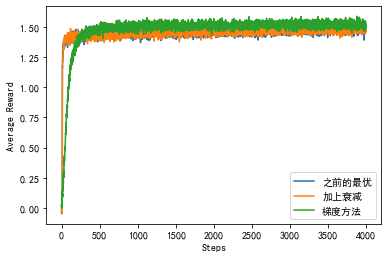

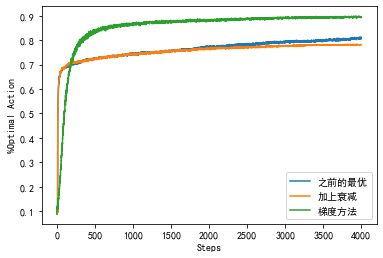

In [114]:
rewards=np.load('3.npy')
acc=np.load('4.npy')
print('以下为不同方案的期望回报:')
print(np.average(rewards,1))
optimal_id=np.argmax(np.average(rewards,1))
print('最优的方案是:{}'.format(newsettings[optimal_id]))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.plot([i for i in range(4000)],rewards[0],label=r'之前的最优')
plt.plot([i for i in range(4000)],rewards[1],label=r'加上衰减')
plt.plot([i for i in range(4000)],rewards[2],label=r'梯度方法')
plt.legend()
plt.show()
plt.xlabel('Steps')
plt.ylabel('%Optimal Action')
plt.plot([i for i in range(4000)],acc[0],label=r'之前的最优')
plt.plot([i for i in range(4000)],acc[1],label=r'加上衰减')
plt.plot([i for i in range(4000)],acc[2],label=r'梯度方法')
plt.legend()
plt.show()

当最大step增大至4000时，原方案加上衰减可以得到更好的效果,梯度方法的效果最好。

#### nonstationary情况

In [91]:
settings['stationary']=False
#rewards,acc=experiment(settings)
#np.save('5.npy',rewards)
#np.save('6.npy',acc)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [40:24<00:00,  1.21s/it]


我们选取几个具有代表性的画图。

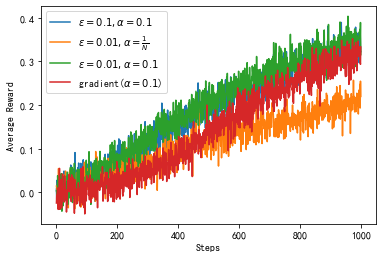

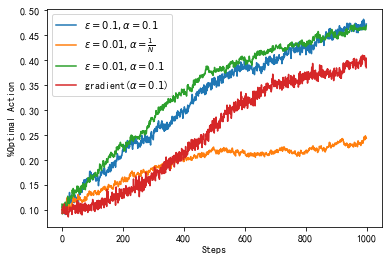

In [104]:
rewards=np.load('5.npy')
acc=np.load('6.npy')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.plot([i for i in range(1000)],rewards[14],label=r'$\epsilon=0.1,\alpha=0.1$')
plt.plot([i for i in range(1000)],rewards[24],label=r'$\epsilon=0.01,\alpha=\frac{1}{N}$')
plt.plot([i for i in range(1000)],rewards[26],label=r'$\epsilon=0.01,\alpha=0.1$')
plt.plot([i for i in range(1000)],rewards[36],label=r'gradient($\alpha=0.1$)')
plt.legend()
plt.show()
plt.xlabel('Steps')
plt.ylabel('%Optimal Action')
plt.plot([i for i in range(1000)],acc[14],label=r'$\epsilon=0.1,\alpha=0.1$')
plt.plot([i for i in range(1000)],acc[24],label=r'$\epsilon=0.01,\alpha=\frac{1}{N}$')
plt.plot([i for i in range(1000)],acc[26],label=r'$\epsilon=0.01,\alpha=0.1$')
plt.plot([i for i in range(1000)],acc[36],label=r'gradient($\alpha=0.1$)')
plt.legend()
plt.show()

从图中可以看出，固定的$\alpha$显著优于sample-average，gradient方法则表现一般。

以下为不同方案的期望回报:
[0.07755098 0.08094969 0.19498871 0.1742808  0.17146449 0.17094018
 0.08570517 0.08278923 0.19329957 0.17840511 0.17636317 0.16965726
 0.15651818 0.15429434 0.18028653 0.16082134 0.16065201 0.15384893
 0.14999447 0.15164381 0.19415759 0.17731446 0.17074392 0.16739302
 0.11169941 0.11011692 0.19325474 0.17621146 0.18110069 0.17097068
 0.09797137 0.09613104 0.19806545 0.17950617 0.17761741 0.17199832
 0.14098736 0.14267759 0.13937543 0.13254977 0.13407754 0.13187371]
最优的方案是32号:{'epsilon': 0.01, 'epsilon_decreasing': True, 'alpha': 0.1, 'initial_values': None}


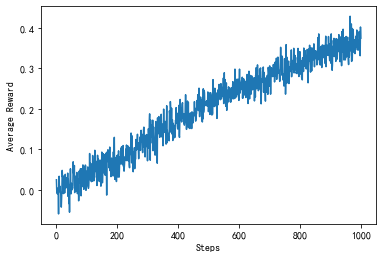

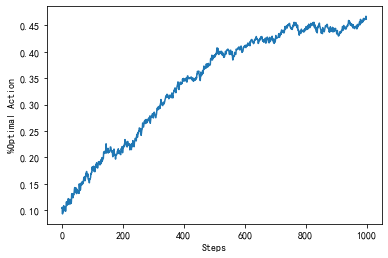

In [93]:
optimal_id=np.argmax(np.average(rewards,1))
print('以下为不同方案的期望回报:')
print(np.average(rewards,1))
print('最优的方案是{}号:{}'.format(optimal_id,settings[optimal_id]))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.plot([i for i in range(1000)],rewards[optimal_id])
plt.show()
plt.xlabel('Steps')
plt.ylabel('%Optimal Action')
plt.plot([i for i in range(1000)],acc[optimal_id])
plt.show()

尽管目前的最优方案是32号:{'epsilon': 0.01, 'epsilon_decreasing': True, 'alpha': 0.1, 'initial_values': None}，但是当前最大步数较小，各方案尚未达到其上限。

由于计算量过大，我们不做充分的进一步探索，仅做一个简单的对比。我们将最大步数调至10000，只考虑四个方案：

* 24 {'epsilon': 0.01, 'epsilon_decreasing': False, 'alpha': 0, 'initial_values': None}
* 26 {'epsilon': 0.01, 'epsilon_decreasing': False, 'alpha': 0.1, 'initial_values': None}
* 32 {'epsilon': 0.01, 'epsilon_decreasing': True, 'alpha': 0.1, 'initial_values': None}
* 37 gradient {'alpha': 0.1, 'alpha_average': 0.1}

在这里我们定性地分析在动态情况下，$\alpha$的选取、$\epsilon$是否衰减的作用，以及$\epsilon$-greedy method和gradient method的比较。

In [4]:
newsettings={}
newsettings['k']=10
newsettings['times']=2000
newsettings['n']=10000
newsettings['stationary']=False
newsettings[0]=settings[24]   
newsettings[1]=settings[26]
newsettings[2]=settings[32]
newsettings[3]=settings[37]
#rewards,acc=experiment(newsettings)
#np.save('7.npy',rewards)
#np.save('8.npy',acc)

以下为不同方案的期望回报:
[0.67905375 0.88842189 0.87599955 0.65254536]
最优的方案是:{'epsilon': 0.01, 'epsilon_decreasing': False, 'alpha': 0.1, 'initial_values': None}


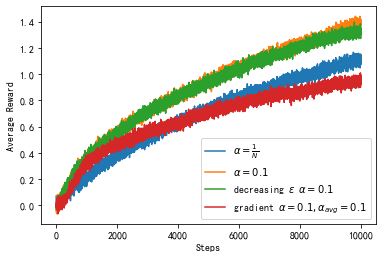

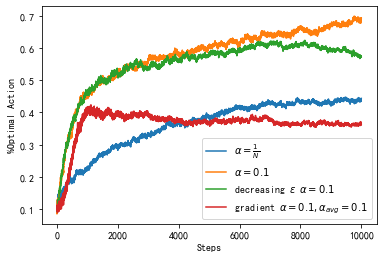

In [5]:
rewards=np.load('7.npy')
acc=np.load('8.npy')
print('以下为不同方案的期望回报:')
print(np.average(rewards,1))
optimal_id=np.argmax(np.average(rewards,1))
print('最优的方案是:{}'.format(newsettings[optimal_id]))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.plot([i for i in range(10000)],rewards[0],label=r'$\alpha=\frac{1}{N}$')
plt.plot([i for i in range(10000)],rewards[1],label=r'$\alpha=0.1$')
plt.plot([i for i in range(10000)],rewards[2],label=r'decreasing $\epsilon$ $\alpha=0.1$')
plt.plot([i for i in range(10000)],rewards[3],label=r'gradient $\alpha=0.1,\alpha_{avg}=0.1$')
plt.legend()
plt.show()
plt.xlabel('Steps')
plt.ylabel('%Optimal Action')
plt.plot([i for i in range(10000)],acc[0],label=r'$\alpha=\frac{1}{N}$')
plt.plot([i for i in range(10000)],acc[1],label=r'$\alpha=0.1$')
plt.plot([i for i in range(10000)],acc[2],label=r'decreasing $\epsilon$ $\alpha=0.1$')
plt.plot([i for i in range(10000)],acc[3],label=r'gradient $\alpha=0.1,\alpha_{avg}=0.1$')
plt.legend()
plt.show()

在动态情况下，$\epsilon$衰减作用有限，梯度方法表现较差。$\alpha$设为固定值非常有必要。